Epoch 1/5


/home/chafi/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


938/938 - 6s - 7ms/step - accuracy: 0.8074 - loss: 0.5286 - val_accuracy: 0.8537 - val_loss: 0.3920 - learning_rate: 0.0010
Epoch 2/5
938/938 - 6s - 6ms/step - accuracy: 0.8796 - loss: 0.3350 - val_accuracy: 0.8773 - val_loss: 0.3347 - learning_rate: 0.0010
Epoch 3/5
938/938 - 5s - 6ms/step - accuracy: 0.8936 - loss: 0.2895 - val_accuracy: 0.8924 - val_loss: 0.3044 - learning_rate: 0.0010
Epoch 4/5
938/938 - 5s - 6ms/step - accuracy: 0.9053 - loss: 0.2596 - val_accuracy: 0.8974 - val_loss: 0.2843 - learning_rate: 0.0010
Epoch 5/5
938/938 - 5s - 6ms/step - accuracy: 0.9145 - loss: 0.2344 - val_accuracy: 0.9029 - val_loss: 0.2679 - learning_rate: 0.0010
313/313 - 1s - 2ms/step - accuracy: 0.9029 - loss: 0.2679

Test accuracy: 0.902899980545044


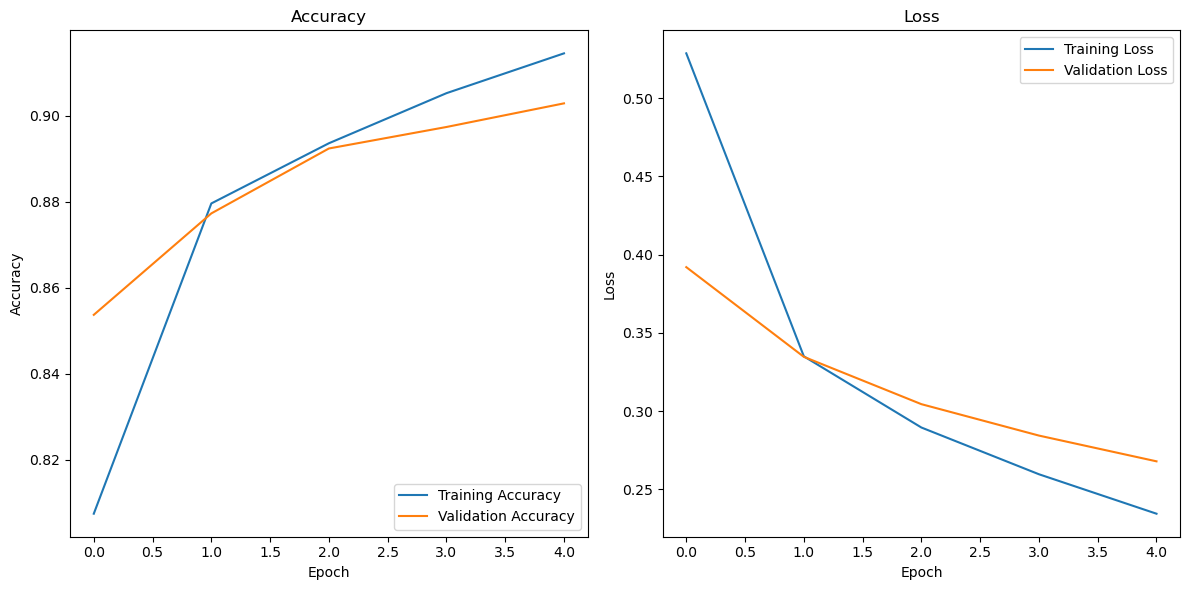

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


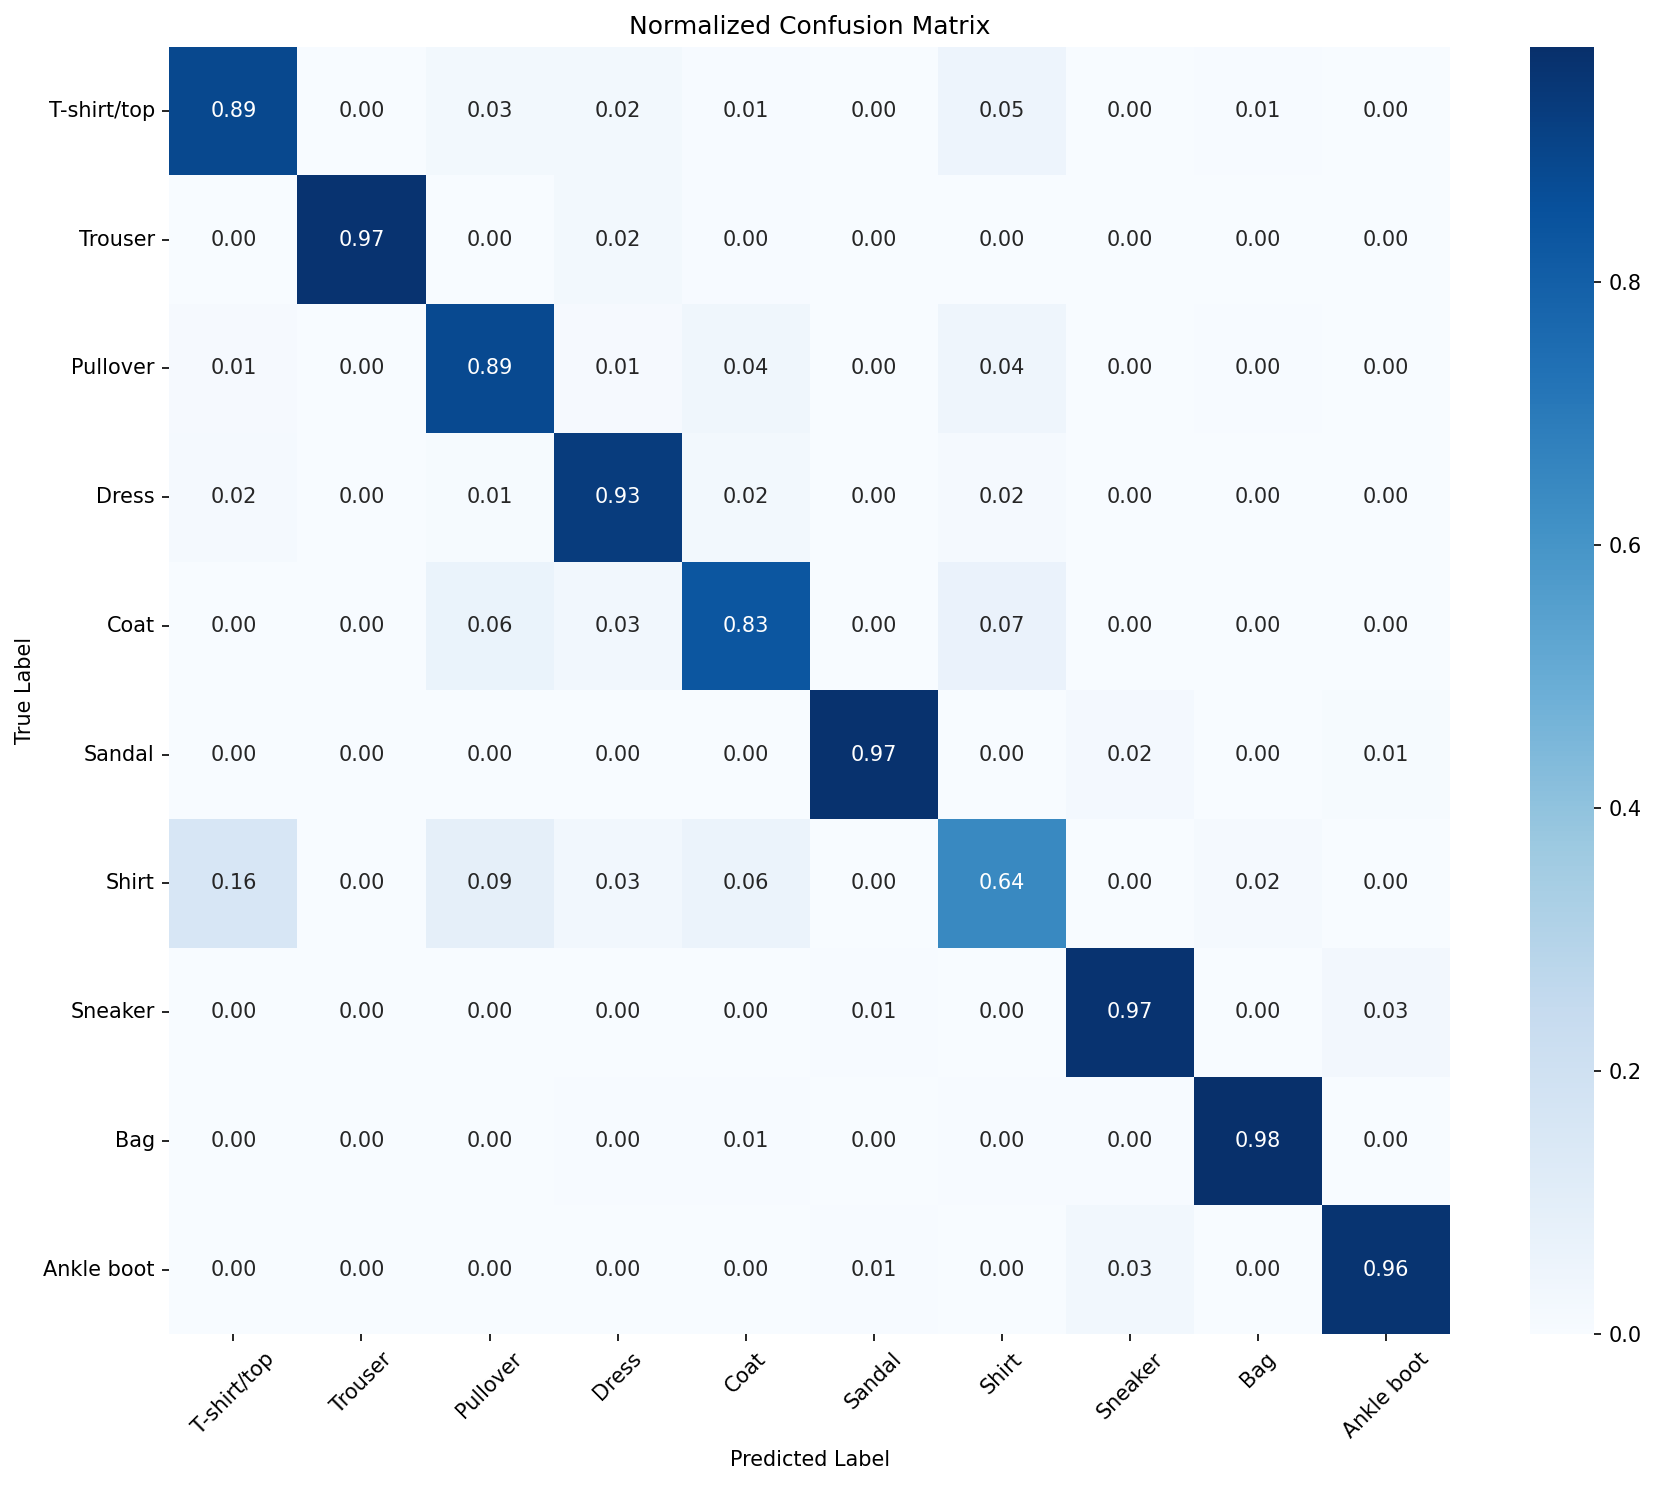

         Class  Accuracy
0  T-shirt/top     0.891
1      Trouser     0.967
2     Pullover     0.885
3        Dress     0.931
4         Coat     0.835
5       Sandal     0.968
6        Shirt     0.644
7      Sneaker     0.966
8          Bag     0.979
9   Ankle boot     0.963


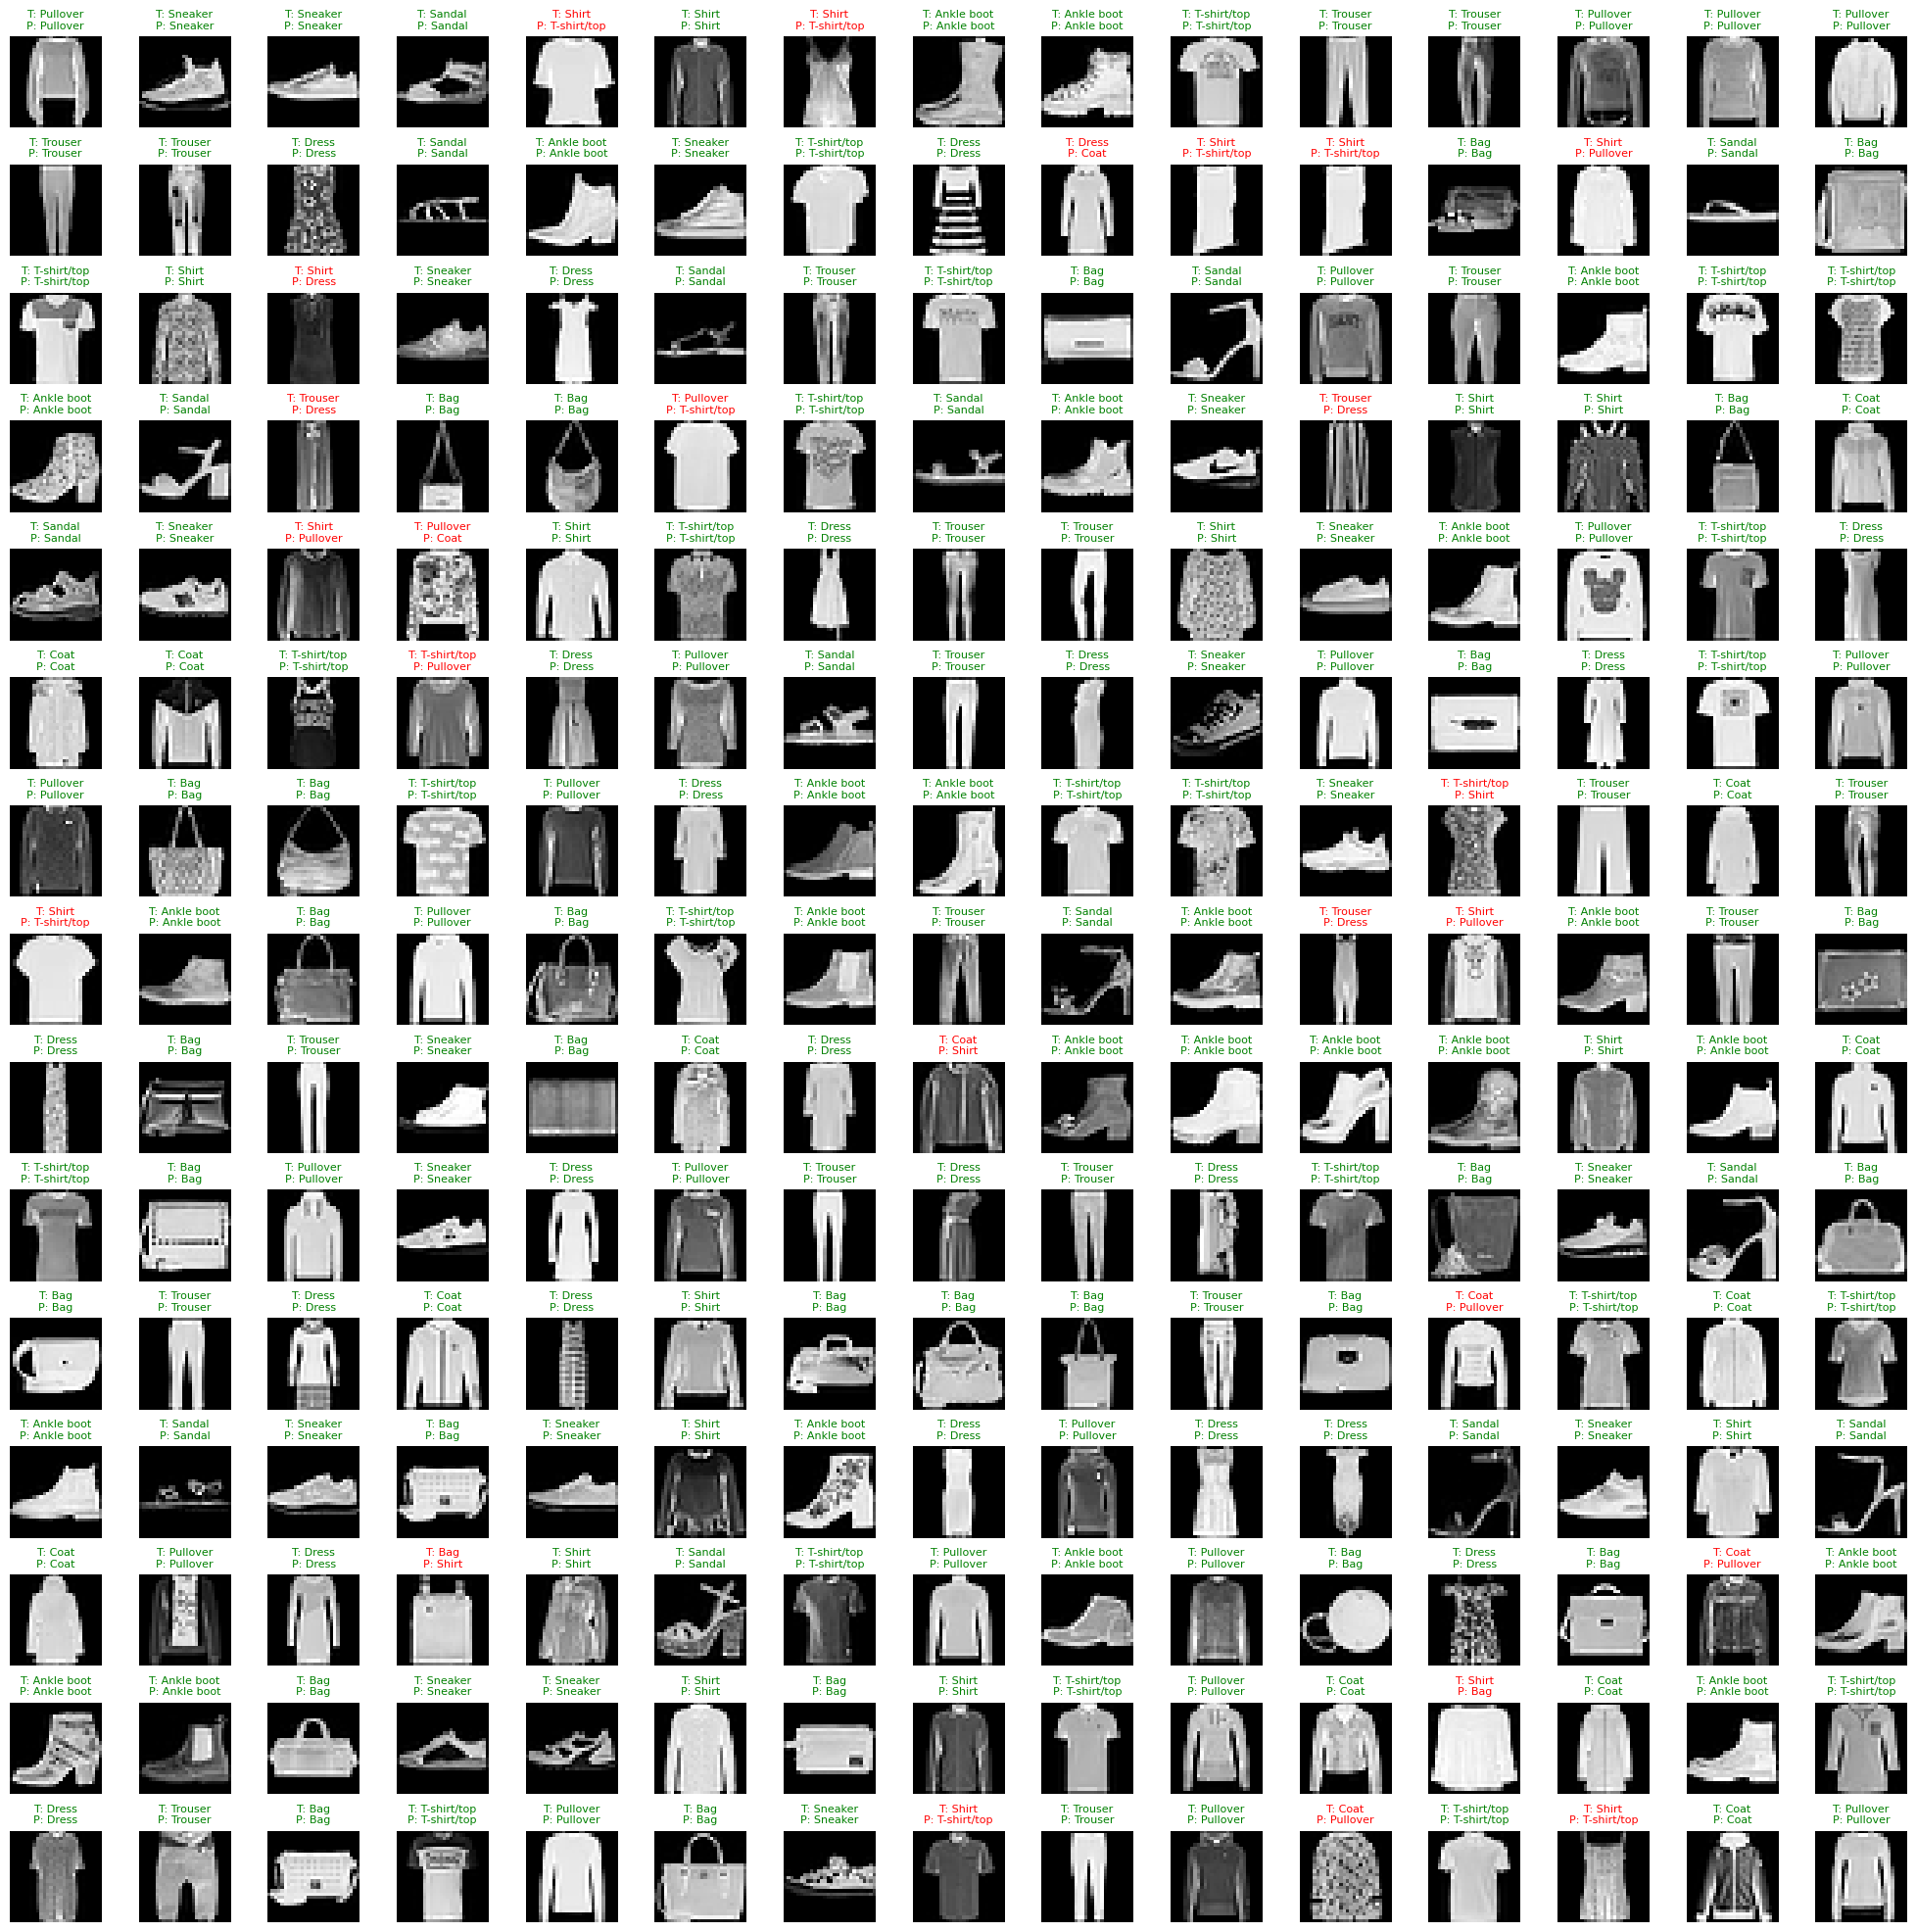

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define constants
EPOCHS = 5
BATCH_SIZE = 64
IMG_HEIGHT, IMG_WIDTH = 28, 28
NUM_CLASSES = 10
NUM_IMAGES_IN_GRID = 15  # Adjust as needed for the grid

# Load and preprocess data
def load_and_preprocess_data():
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
    train_images = train_images.astype('float32') / 255.0
    test_images = test_images.astype('float32') / 255.0
    train_images = np.expand_dims(train_images, -1)
    test_images = np.expand_dims(test_images, -1)
    return (train_images, train_labels), (test_images, test_labels)

# Create CNN model
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(NUM_CLASSES)
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

# Train the model
def train_model(model, train_images, train_labels, test_images, test_labels):
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(
        train_images, train_labels,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(test_images, test_labels),
        callbacks=[lr_scheduler, early_stopping],
        verbose=2
    )
    
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
    print(f'\nTest accuracy: {test_acc}')
    
    return history

# Plot training results
def plot_results(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')

    plt.tight_layout()
    plt.show()

# Plot normalized confusion matrix
def plot_confusion_matrix(test_labels, predictions, class_names):
    predicted_labels = np.argmax(predictions, axis=1)
    cm = confusion_matrix(test_labels, predicted_labels, normalize='true')  # Normalized confusion matrix
    
    plt.figure(figsize=(12, 10), dpi=150)
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Calculate and display class-wise accuracy
def classwise_accuracy(test_labels, predictions, class_names):
    predicted_labels = np.argmax(predictions, axis=1)
    cm = confusion_matrix(test_labels, predicted_labels)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    df = pd.DataFrame({
        'Class': class_names,
        'Accuracy': class_accuracy
    })
    print(df)

# Mapping labels to their corresponding class names
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Execute steps
(train_images, train_labels), (test_images, test_labels) = load_and_preprocess_data()
model = create_model()
history = train_model(model, train_images, train_labels, test_images, test_labels)
plot_results(history)

# Make predictions
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)

# Plot confusion matrix and class-wise accuracy
plot_confusion_matrix(test_labels, predictions, class_names)
classwise_accuracy(test_labels, predictions, class_names)

# Display images in a grid with predictions
def display_image_grid_with_predictions(images, true_labels, predictions, class_names, grid_width=15, grid_height=15):
    fig, axes = plt.subplots(grid_height, grid_width, figsize=(25, 25), dpi=100)
    axes = axes.ravel()

    for i in np.arange(0, grid_width * grid_height):
        index = np.random.randint(0, len(images))
        image = images[index].squeeze()
        true_label = true_labels[index]
        predicted_label = np.argmax(predictions[index])
        color = 'green' if predicted_label == true_label else 'red'
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"T: {class_names[true_label]}\nP: {class_names[predicted_label]}", fontsize=8, color=color)
        axes[i].axis('off')
    
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

# Use this function to display a grid of images with predictions
display_image_grid_with_predictions(test_images, test_labels, predictions, class_names)
